# SVM
1. find the best kernel in terms of accuracy (dataset more or less balanced) 
2. save the classification report for all the kernels (like in A1)
3. plot the decision boundary with best kernel
4. remove SVs and do again
5. lastly implement SMO

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn
from sklearn import decomposition
from sklearn.svm import SVC #support vector classifier class

### Data Visualisation

In [2]:
# data = pd.read_csv('./health_data.csv').values
# print(type(data), data.shape)
# print("class distribution",np.bincount(data[:,-1]))
# np.random.shuffle(data)
# np.save('health_data.npy',data)
data=np.load('health_data.npy')
data[data[:,-1]==0,-1]=-1

In [3]:
train_data=data[0:490,:].astype('float64')
TEST_data=data[490:700,:].astype('float64')

mean = train_data[:,:-1].mean(axis=0,keepdims=True)
stddev = train_data[:,:-1].std(axis=0,keepdims=True)

# normalising data since we'll use optimization algorithms. No closed form solutions exists here.
train_data[:,:-1]-=mean
TEST_data[:,:-1]-=mean
train_data[:,:-1]/=stddev
TEST_data[:,:-1]/=stddev

X_TEST,y_TEST = TEST_data[:,:-1],TEST_data[:,-1]
X_train,y_train = train_data[:,:-1],train_data[:,-1]
print(X_train.shape, y_train.shape)
print(X_TEST.shape, y_TEST.shape)

(490, 3) (490,)
(210, 3) (210,)


In [4]:
from mpl_toolkits.mplot3d import Axes3D
X_train_class_0 = train_data[train_data[:,-1]==-1][:,:-1]
X_train_class_1 = train_data[train_data[:,-1]==1][:,:-1]
print(X_train_class_0.shape, X_train_class_1.shape)
X_test_class_0 = TEST_data[TEST_data[:,-1]==-1][:,:-1]
X_test_class_1 = TEST_data[TEST_data[:,-1]==1][:,:-1]
print(X_test_class_0.shape, X_test_class_1.shape)

(292, 3) (198, 3)
(108, 3) (102, 3)


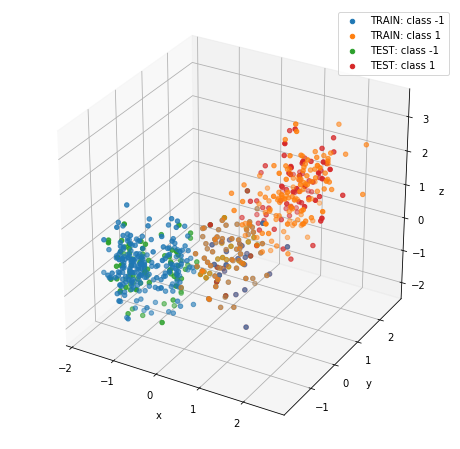

In [6]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(X_train_class_0[:,0], X_train_class_0[:,1], X_train_class_0[:,2], label='TRAIN: class -1')
ax.scatter3D(X_train_class_1[:,0], X_train_class_1[:,1], X_train_class_1[:,2], label='TRAIN: class 1')
ax.scatter3D(X_test_class_0[:,0], X_test_class_0[:,1], X_test_class_0[:,2], label='TEST: class -1')
ax.scatter3D(X_test_class_1[:,0], X_test_class_1[:,1], X_test_class_1[:,2], label='TEST: class 1')
plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.savefig('health_dataset.png', dpi = 300)
plt.show()

In [5]:
def classification_performance_metrics(y_pred, y_true):
    n=y_true.shape
    tp_indices = y_pred==y_true
    tp = y_true[tp_indices]
    true_y_per_class = np.bincount(y_true)
    labels = true_y_per_class.shape[0]
    tp_per_class = np.zeros((labels,))
    tp_per_class[:np.bincount(tp).shape[0]] = np.bincount(tp)
    predicted_y_per_class = np.zeros((labels,))
    predicted_y_per_class[:np.bincount(y_pred).shape[0]] = np.bincount(y_pred)
    acc = 100 * tp_per_class.sum()/n
    #precision, recall, F1 for each class
    for i in range(tp_per_class.shape[0]):
        TP = tp_per_class[i]
        TN = tp_per_class.sum() - TP
        FP = predicted_y_per_class[i] - TP
        FN = true_y_per_class[i] - TP
        precision = TP/(TP+FP) if TP+FP!=0 else 0
        recall = TP/(TP+FN) if TP+FN!=0 else 0
        F1 = 2*TP/(2*TP+FP+FN) if TP+FP+FN!=0 else 0
        FPR = FP/(FP+TN) if FP+TN!=0 else 0    
    performance={}
    performance['acc']=acc
    performance['precision']=precision
    performance['TPR']=recall
    performance['recall']=recall
    performance['F1']=F1
    performance['FPR']=FPR
    return performance

def accuracy(y1,y2):
    return 100*(y1==y2).sum()/y1.shape[0]

In [6]:
comparison_train_acc, comparison_test_acc, comparison_F1, comparison_SV = [],[],[],[]

### Linear SVM

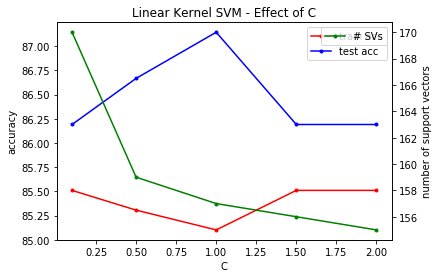

In [7]:
Cs=[0.1,0.5,1,1.5,2]
train_acc, test_acc, no_of_sv = [],[],[]
for C in Cs:
    svclassifier = SVC(kernel='linear',C=C)
    svclassifier.fit(X_train, y_train)
    y_pred_train = svclassifier.predict(X_train)
    y_pred_TEST = svclassifier.predict(X_TEST)
    train_acc.append(accuracy(y_pred_train,y_train))
    test_acc.append(accuracy(y_pred_TEST,y_TEST))
    no_of_sv.append(svclassifier.support_vectors_.shape[0])
fig,ax = plt.subplots()
plt.title('Linear Kernel SVM - Effect of C')
ax.plot(Cs, train_acc, label='train acc',c='r',marker='.')
ax.plot(Cs, test_acc, label='test acc',c='b',marker='.')
ax.set_xlabel('C')
ax.set_ylabel('accuracy')
plt.legend()
ax2=ax.twinx()
ax2.plot(Cs, no_of_sv, label='# SVs', c='g',marker='.')
ax2.set_ylabel('number of support vectors')
plt.legend()
fig.savefig('LinearSVM.png')
plt.show()
# print(svclassifier.support_vectors_.shape)
# print(X_train.shape)
# print(svclassifier.dual_coef_.shape)
# print(svclassifier.dual_coef_)

In [8]:
svclassifier = SVC(kernel='linear',C=1)
svclassifier.fit(X_train, y_train)
y_pred_train = svclassifier.predict(X_train)
y_pred_TEST = svclassifier.predict(X_TEST)
comparison_train_acc.append(accuracy(y_pred_train,y_train))
comparison_test_acc.append(accuracy(y_pred_TEST,y_TEST))
comparison_F1.append(classification_performance_metrics(y_pred_TEST.astype('int64')+1, y_TEST.astype('int64')+1)['F1'])
comparison_SV.append(svclassifier.support_vectors_.shape[0])
# print(comparison_train_acc, comparison_test_acc, comparison_F1, comparison_SV)

### Polynomial kernel SVM

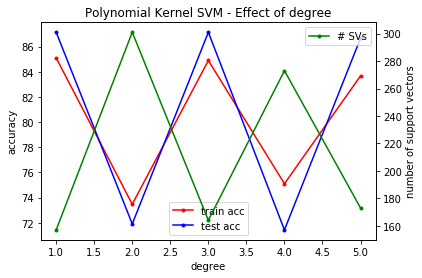

In [9]:
degrees=[1,2,3,4,5]
train_acc, test_acc, no_of_sv = [],[],[]
for deg in degrees:
    svclassifier = SVC(kernel='poly',degree=deg,gamma=1)
    svclassifier.fit(X_train, y_train)
    y_pred_train = svclassifier.predict(X_train)
    y_pred_TEST = svclassifier.predict(X_TEST)
    train_acc.append(accuracy(y_pred_train,y_train))
    test_acc.append(accuracy(y_pred_TEST,y_TEST))
    no_of_sv.append(svclassifier.support_vectors_.shape[0])
fig,ax = plt.subplots()
plt.title('Polynomial Kernel SVM - Effect of degree')
ax.plot(degrees, train_acc, label='train acc',c='r',marker='.')
ax.plot(degrees, test_acc, label='test acc',c='b',marker='.')
ax.set_xlabel('degree')
ax.set_ylabel('accuracy')
plt.legend()
ax2=ax.twinx()
ax2.plot(degrees, no_of_sv, label='# SVs', c='g',marker='.')
ax2.set_ylabel('number of support vectors')
plt.legend()
fig.savefig('PolynomialSVM.png')
plt.show()

### Gaussian Kernel SVM

In [10]:
Cs=[0.01, 0.1,0.5,1,2]
gammas=[0.01, 0.1,0.5,1,2]
grid_search_train_acc=np.zeros((len(Cs),len(gammas)))
grid_search_test_acc=np.zeros((len(Cs),len(gammas)))
for i,c in enumerate(Cs):
    for j,gamma in enumerate(gammas):
        svclassifier = SVC(kernel='rbf',C=c,gamma=gamma)
        svclassifier.fit(X_train, y_train)
        y_pred_train = svclassifier.predict(X_train)
        y_pred_TEST = svclassifier.predict(X_TEST)
        grid_search_train_acc[i,j]=accuracy(y_pred_train,y_train)
        grid_search_test_acc[i,j]=accuracy(y_pred_TEST,y_TEST)
grid_search_test_acc=np.round(grid_search_test_acc,2)
grid_search_train_acc=np.round(grid_search_train_acc,2)
# print(grid_search_test_acc,grid_search_train_acc)
df = pd.DataFrame(data=grid_search_test_acc,index=Cs,columns=gammas)
df.to_csv('RBF_Grid_test.csv')
df = pd.DataFrame(data=grid_search_train_acc,index=Cs,columns=gammas)
df.to_csv('RBF_Grid_train.csv')

In [11]:
svclassifier = SVC(kernel='rbf',C=2,gamma=0.01)
svclassifier.fit(X_train, y_train)
y_pred_train = svclassifier.predict(X_train)
y_pred_TEST = svclassifier.predict(X_TEST)
comparison_train_acc.append(accuracy(y_pred_train,y_train))
comparison_test_acc.append(accuracy(y_pred_TEST,y_TEST))
comparison_F1.append(classification_performance_metrics(y_pred_TEST.astype('int64')+1, y_TEST.astype('int64')+1)['F1'])
comparison_SV.append(svclassifier.support_vectors_.shape[0])
print(comparison_train_acc, comparison_test_acc, comparison_F1, comparison_SV)

[85.10204081632654, 85.10204081632654] [87.14285714285714, 87.14285714285714] [0.8656716417910447, 0.8615384615384616] [157, 185]


In [12]:
comparison_stats=np.array([comparison_train_acc, comparison_test_acc, comparison_F1, comparison_SV]).T
df = pd.DataFrame(data=np.round(comparison_stats,2))
df.to_csv('kernel_comparison_stats.csv')

### PCA

[0.76035966 0.1872517  0.05238864]


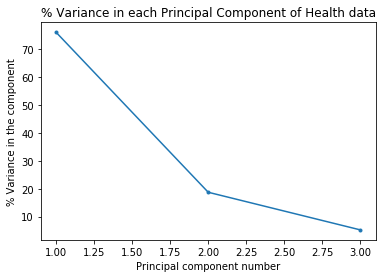

In [13]:
pca=decomposition.PCA(n_components=3)
pca.fit(X_train)
variances=pca.explained_variance_ratio_
print(variances)
plt.title('% Variance in each Principal Component of Health data')
plt.xlabel('Principal component number')
plt.ylabel('% Variance in the component')
plt.plot(list(np.arange(1,4,1)),100*variances,marker='.')
plt.savefig('PCA_HealthData.png')
plt.show()

### RBF on PCA-data

In [14]:
pca=decomposition.PCA(n_components=2)
pca.fit(X_train)
transformed_X_train = pca.transform(X_train)
transformed_X_TEST = pca.transform(X_TEST)
svclassifier = SVC(kernel='rbf',C=2,gamma=0.01)
svclassifier.fit(transformed_X_train, y_train)
y_pred_train = svclassifier.predict(transformed_X_train)
y_pred_TEST = svclassifier.predict(transformed_X_TEST)

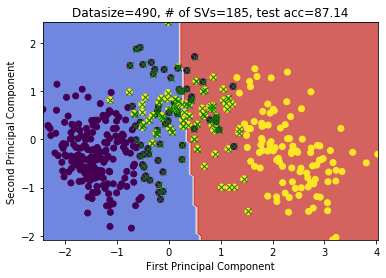

In [15]:
X = transformed_X_train
xrange = np.linspace(X[:,0].min(), X[:,0].max(), 100)
yrange = np.linspace(X[:,1].min(), X[:,1].max(), 100)
grid = [[svclassifier.predict(np.array([xr,yr]).reshape(1,2)) for xr in xrange] for yr in yrange]
grid = np.array(grid).reshape(len(xrange), len(yrange))
plt.title('Datasize=%i, # of SVs=%i, test acc=%.2f'%(X.shape[0],svclassifier.support_.shape[0],accuracy(y_pred_TEST,y_TEST)))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.xlim(X[:,0].min(), X[:,0].max())
plt.ylim(X[:,1].min(), X[:,1].max())
plt.contourf(xrange, yrange, grid, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:,0],X[:,1],c=y_train)
SVs = svclassifier.support_vectors_
plt.scatter(SVs[:,0], SVs[:,1], lw=1,c='green', edgecolors='k',marker='x')
plt.savefig('rbfkernel_1.png')
plt.show()

### remove support vectors

In [16]:
support_vector_indices = svclassifier.support_
indices=np.zeros((transformed_X_train.shape[0]))
indices[support_vector_indices]=1
indices_left = indices==0
new_X_train=transformed_X_train[indices_left]
new_y_train=y_train[indices_left]
print(new_X_train.shape, new_y_train.shape)
svclassifier = SVC(kernel='rbf',C=2,gamma=0.01)
svclassifier.fit(new_X_train, new_y_train)
y_pred_train = svclassifier.predict(new_X_train)
y_pred_TEST = svclassifier.predict(transformed_X_TEST)

(305, 2) (305,)


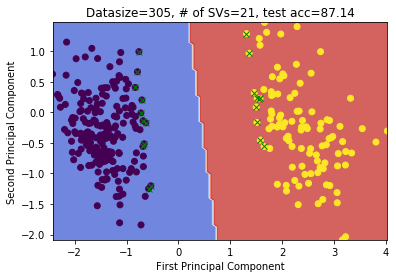

In [17]:
X = new_X_train
xrange = np.linspace(X[:,0].min(), X[:,0].max(), 100)
yrange = np.linspace(X[:,1].min(), X[:,1].max(), 100)
grid = [[svclassifier.predict(np.array([xr,yr]).reshape(1,2)) for xr in xrange] for yr in yrange]
grid = np.array(grid).reshape(len(xrange), len(yrange))
plt.title('Datasize=%i, # of SVs=%i, test acc=%.2f'%(X.shape[0],svclassifier.support_.shape[0],accuracy(y_pred_TEST,y_TEST)))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.xlim(X[:,0].min(), X[:,0].max())
plt.ylim(X[:,1].min(), X[:,1].max())
plt.contourf(xrange, yrange, grid, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:,0],X[:,1],c=new_y_train)
SVs = svclassifier.support_vectors_
plt.scatter(SVs[:,0], SVs[:,1], lw=1,c='green', edgecolors='k',marker='x')
plt.savefig('rbfkernel_2.png')
plt.show()

### Comparison of SMO implementation (from scratch) and LibSVM (sklearn)
sklearn svm uses LibSVM - https://scikit-learn.org/stable/modules/svm.html

In [18]:
class SMOModel:    
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.y = y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set

def linear_kernel(x1, x2):
    return np.dot(x1, x2.T)

# Objective function to optimize
def objective_function(alphas, target, kernel, X_train):
    return np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))

# Decision function
def decision_function(alphas, target, kernel, X_train, x_test, b):
    """Applies the SVM decision function to the input feature vectors in `x_test`."""
    result = np.dot( (alphas * target) , kernel(X_train, x_test) )+ b
    return result

# cite: https://jonchar.net/notebooks/SVM/
def take_step(i1, i2, model):
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model
    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5
    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new
    # Update model threshold
    model.b = b_new
    return 1, model

def examine_example(i2, model):
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2
    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    return 0, model

def train(model):
    numChanged = 0
    examineAll = 1
    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
    return model

In [19]:
data=np.load('health_data.npy').astype('float64')
data[data[:,-1]==0,-1]=-1
mean = data[:,:-1].mean(axis=0,keepdims=True)
stddev = data[:,:-1].std(axis=0,keepdims=True)
data[:,:-1]-=mean
data[:,:-1]/=stddev

In [21]:
import time
dataset_sizes=np.arange(100,1000,100)
SMO_times=[]
LibSVM_times=[]
for size in dataset_sizes:
    X=data[:size,:-1]
    y=data[:size,-1]
    t1=time.time()
    # Set model parameters and initial values
    C = 1
    m = len(X)
    initial_alphas = np.zeros(m)
    initial_b = 0.0
    # Set tolerances
    tol = 0.01 # error tolerance
    eps = 0.01 # alpha tolerance
    # Instantiate model
    model = SMOModel(X, y, C, linear_kernel, initial_alphas, initial_b, np.zeros(m))
    # Initialize error cache
    initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
    model.errors = initial_error
    output = train(model)
    t2=time.time()
    SMO_times.append(t2-t1)
    t1=time.time()
    svclassifier = SVC(kernel='linear',C=1)
    svclassifier.fit(X, y)
    t2=time.time()
    LibSVM_times.append(ta2-t1)
#     print(size, SMO_times[-1], LibSVM_times[-1])
times=np.array([SMO_times, LibSVM_times])
np.save('times.npy',times)

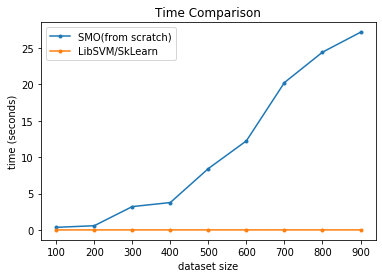

In [22]:
plt.title('Time Comparison')
plt.xlabel('dataset size')
plt.ylabel('time (seconds)')
plt.plot(dataset_sizes, SMO_times,label='SMO(from scratch)',marker='.')
plt.plot(dataset_sizes, LibSVM_times,label='LibSVM/SkLearn',marker='.')
plt.legend()
plt.savefig('times.png')
plt.show()

### number of support vectors with dataset size

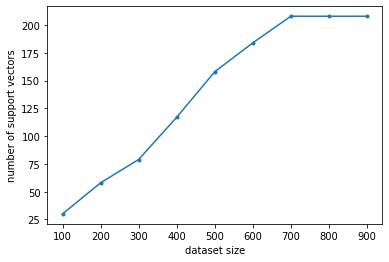

In [23]:
data=np.load('health_data.npy')
data[data[:,-1]==0,-1]=-1
data=data[:,:].astype('float64')
mean = data[:,:-1].mean(axis=0,keepdims=True)
stddev = data[:,:-1].std(axis=0,keepdims=True)
data[:,:-1]-=mean
data[:,:-1]/=stddev
dataset_sizes=np.arange(100,1000,100)
no_of_SVs=[]
for size in dataset_sizes:
    X=data[:size,:-1]
    y=data[:size,-1]
    svclassifier = SVC(kernel='linear',C=1)
    svclassifier.fit(X, y)
    no_of_SVs.append(svclassifier.support_.shape[0])
plt.xlabel('dataset size')
plt.ylabel('number of support vectors')
plt.plot(dataset_sizes,no_of_SVs,marker='.')
plt.savefig('no_of_svs.png')
plt.show()